In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cluster_jzar
import climb_jor

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:
- `Independent features (clustered)` => <b>In this notebook we will work on this one
- How good the route is (the higher the better)
- Grade, Location, sex, heigh (defined by user)


# Clustering Routes

First we retrieve the features dataframe

In [3]:
routes_features = pd.read_csv('../data/routes_features.csv',low_memory=False, index_col=0)

In [4]:
print(routes_features.shape)
routes_features.tail(5)

(55087, 19)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,sex_ratio,yellow_id_mean,first_ascent_mean
55082,55082,zaf,van stadens,the beach,bush biscuit,2,0.0,1.0,0.0,0,0,0,0,44.0,NaN,NaN,0.0,0.0,0.0
55083,55083,zaf,van stadens,the beach,funky chicken,2,0.0,0.0,0.0,0,0,0,0,38.0,0.0,1.0,0.0,0.0,0.0
55084,55084,zaf,van stadens,the beach,out of control,2,0.0,0.0,0.0,0,0,0,0,36.0,NaN,NaN,0.0,0.0,0.0
55085,55085,zaf,van stadens,the beach,sheathless,2,0.0,0.0,0.0,0,1,0,-1,39.5,0.0,2.0,0.0,255.0,0.0
55086,55086,zaf,waterval boven,baboon buttress,pretenders,2,0.0,1.0,0.0,0,0,0,0,49.0,0.0,NaN,0.0,255.0,0.0


## Prepare the dataframe for clustering

In [5]:
# Drop not interesting features
X = routes_features[['ascents_count','repeat_sum','chiped_sum','soft_sum','hard_sum','traditional_sum','tall_recommend_sum','sex_ratio','yellow_id_mean','first_ascent_mean']]

In [6]:
X.corr()

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
ascents_count,1.000000,0.316998,0.083650,0.726797,0.571624,0.045267,0.072232,0.043329,0.211865,-0.057708
repeat_sum,0.316998,1.000000,0.015068,0.196296,0.157400,0.090747,0.043418,-0.000462,0.075402,-0.009995
chiped_sum,0.083650,0.015068,1.000000,0.087191,0.072029,-0.005889,0.014043,-0.024995,0.021241,0.008091
soft_sum,0.726797,0.196296,0.087191,1.000000,0.213373,0.003320,0.129814,0.001822,0.166405,-0.033409
hard_sum,0.571624,0.157400,0.072029,0.213373,1.000000,0.023702,-0.037180,-0.003030,0.152198,-0.041778
traditional_sum,0.045267,0.090747,-0.005889,0.003320,0.023702,1.000000,-0.002960,-0.006420,0.040114,-0.011163
tall_recommend_sum,0.072232,0.043418,0.014043,0.129814,-0.037180,-0.002960,1.000000,0.004718,0.008244,-0.002112
sex_ratio,0.043329,-0.000462,-0.024995,0.001822,-0.003030,-0.006420,0.004718,1.000000,0.039341,-0.049543
yellow_id_mean,0.211865,0.075402,0.021241,0.166405,0.152198,0.040114,0.008244,0.039341,1.000000,-0.037276
first_ascent_mean,-0.057708,-0.009995,0.008091,-0.033409,-0.041778,-0.011163,-0.002112,-0.049543,-0.037276,1.000000


<AxesSubplot:>

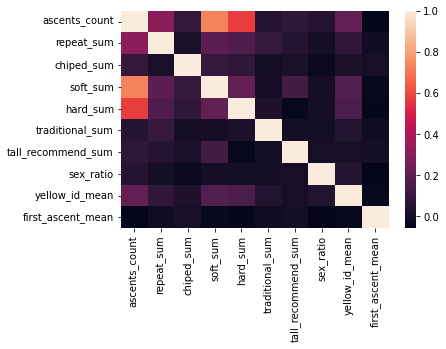

In [7]:
sns.heatmap(X.corr())

Not a big correlation between features

In [8]:
X

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
0,6,0.0,0.0,1,1,0,-1,0.0,0.0,0.0
1,5,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2,4,0.0,0.0,0,1,0,-1,0.0,0.0,0.0
3,3,0.0,0.0,0,1,0,0,0.0,0.0,0.0
4,2,0.0,0.0,1,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
55082,2,0.0,0.0,0,0,0,0,0.0,0.0,0.0
55083,2,0.0,0.0,0,0,0,0,0.0,0.0,0.0
55084,2,0.0,0.0,0,0,0,0,0.0,0.0,0.0
55085,2,0.0,0.0,0,1,0,-1,0.0,255.0,0.0


In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(55087, 10)


,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,yellow_id_mean,first_ascent_mean
0,-0.238698,-0.219455,-0.114004,0.035441,0.181671,-0.098003,-1.058704,-0.613149,-1.077842,-0.19821
1,-0.283301,-0.219455,-0.114004,-0.342408,-0.425042,-0.098003,-0.024555,-0.613149,-1.077842,-0.19821
2,-0.327905,-0.219455,-0.114004,-0.342408,0.181671,-0.098003,-1.058704,-0.613149,-1.077842,-0.19821


### Check the PCA

In [10]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.22874663, 0.1074876 , 0.10479388, 0.10355133, 0.09691813,
       0.09478599, 0.09129738, 0.08200777, 0.07407682, 0.01633447])

All pcas have more or less hte same variance ratio

# Clustering model - K-Means

In [20]:
# K = range(2, 21)
# inertia = []
# silhouette = []

# for k in K:
#     print("Training a K-Means model with {} neighbours! ".format(k))
#     print()
#     kmeans = KMeans(n_clusters=k,
#                     random_state=1234)
#     kmeans.fit(X_scaled_df)
#     filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
#     inertia.append(kmeans.inertia_)
#     silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



I will 3D plot in 2 groups


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

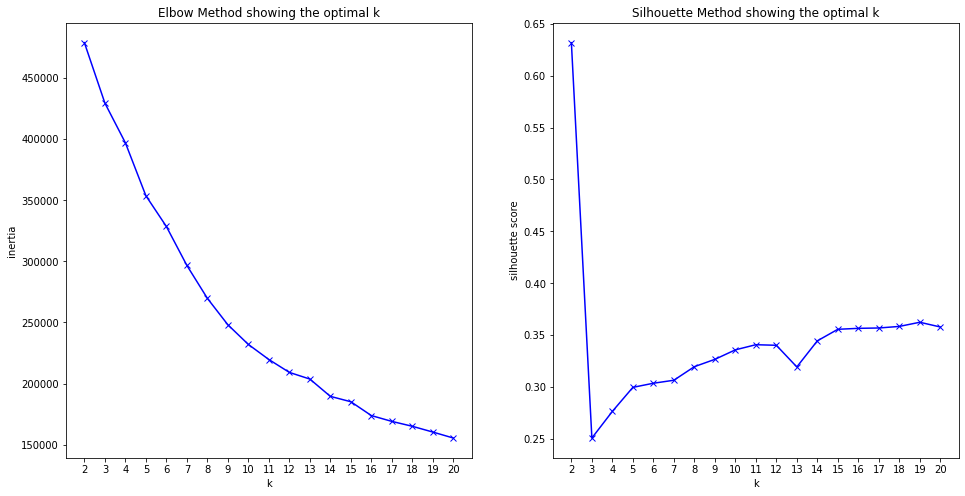

In [21]:
# fig, ax = plt.subplots(1,2,figsize=(16,8))
# ax[0].plot(K, inertia, 'bx-')
# ax[0].set_xlabel('k')
# ax[0].set_ylabel('inertia')
# ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
# ax[0].set_title('Elbow Method showing the optimal k')
# ax[1].plot(K, silhouette, 'bx-')
# ax[1].set_xlabel('k')
# ax[1].set_ylabel('silhouette score')
# ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
# ax[1].set_title('Silhouette Method showing the optimal k')

We see a relatively good score for 5

In [13]:
k = 5
filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
with open(filename, "rb") as file:
    kmeans = pickle.load(file)
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0    22565
1    22295
2     1760
3     7006
4     1461
dtype: int64

In [14]:
clusters

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

### Check the PCA

In [15]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.22874663, 0.1074876 , 0.10479388, 0.10355133, 0.09691813,
       0.09478599, 0.09129738, 0.08200777, 0.07407682, 0.01633447])

Just for fun I will 3D plot but we have 8 groups... the limited human brain..

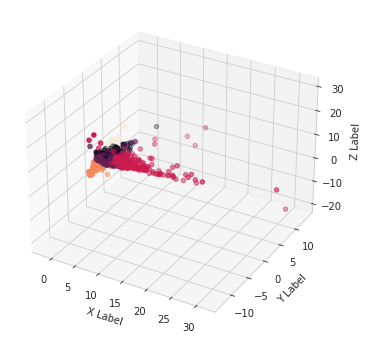

In [16]:
from plot_jzar import *
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[2],color = clusters, fraction = 0.2)

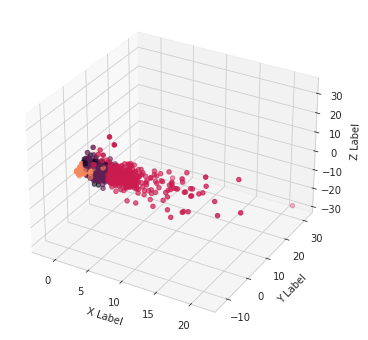

In [17]:
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[3],color = clusters, fraction = 0.2)

And we see that the assigned clusters are not so bad

### Assing each route to a cluster

In [18]:
X_cl = routes_features.copy()
X_cl["cluster"] = pd.Series(clusters)

In [19]:
routes_clustered = X_cl.drop(columns = ['chiped_sum','soft_sum','hard_sum','traditional_sum','sex_ratio'])
print(routes_clustered.shape)
routes_clustered.head()

(55087, 15)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,yellow_id_mean,first_ascent_mean,cluster
0,0,and,montserrat,prohibitivo,el mehir,6,0.0,1.0,-1,49.000000,0.0,2.00,0.0,0.0,0
1,1,and,montserrat,prohibitivo,el pas de la discordia,5,0.0,1.0,0,49.000000,0.0,1.75,0.0,0.0,0
2,2,and,montserrat,prohibitivo,la x,4,0.0,0.0,-1,49.250000,0.0,2.00,0.0,0.0,0
3,3,and,tartareu,bombo suis,tenedor libre,3,0.0,1.0,0,44.333333,0.0,3.00,0.0,0.0,0
4,4,arg,bandurrias,rincon,tendinitis,2,0.0,0.0,1,48.500000,0.0,1.00,0.0,0.0,0


In [20]:
clust_0 = routes_clustered[routes_clustered.cluster == 0]

In [21]:
routes_clustered.cluster.value_counts()

0    22565
1    22295
3     7006
2     1760
4     1461
Name: cluster, dtype: int64

In [22]:
routes_clustered.to_csv('../data/routes_clustered.csv')